In [1]:
import scanpy as sc
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
import helper_fns

In [2]:
dataset = sc.read('filtered_data_500.h5ad')
dataset_raw = dataset
dataset.raw = dataset_raw
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.raw = dataset_raw
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_loader = AnnLoader(dataset[train_indices], batch_size=dataset.shape[0], shuffle=True, convert=encoders)
test_loader = AnnLoader(dataset[test_indices], batch_size=dataset.shape[0], shuffle=True, convert=encoders)
for batch in train_loader:
    X_train = batch.X
    y_train = batch.obs['Manually_curated_celltype']
for batch in test_loader:
    X_test = batch.X
    y_test = batch.obs['Manually_curated_celltype']

Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
clf.score(X_test, y_test)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9103843311160384

In [ ]:
clf

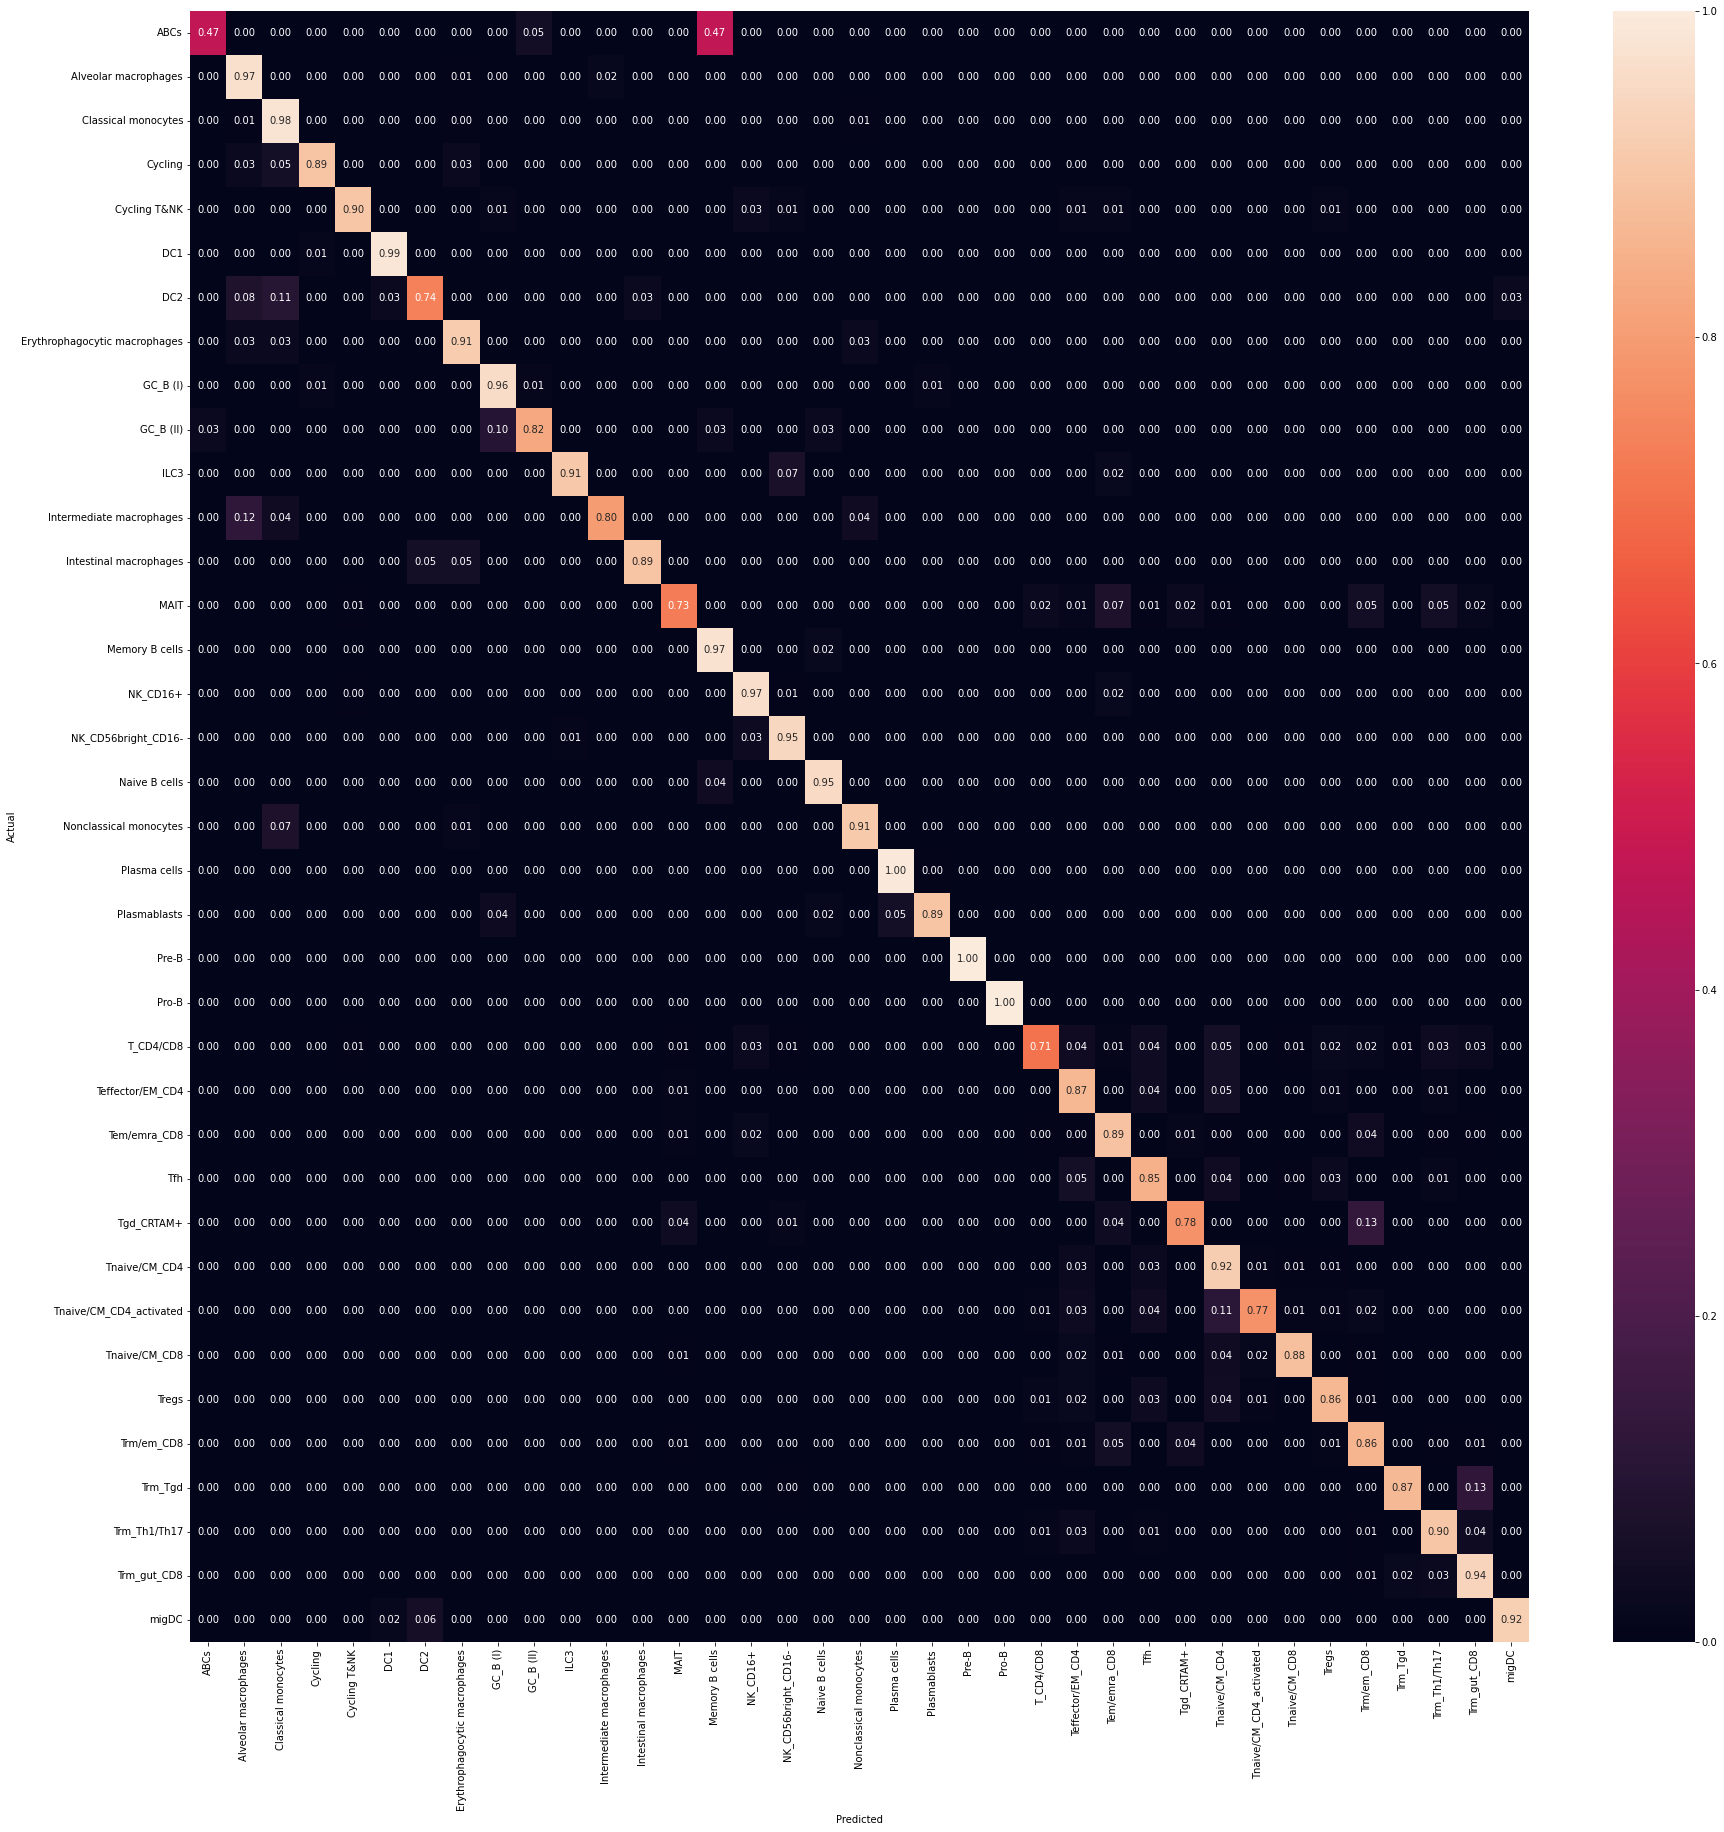

In [4]:
pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test, pred)
# Normalise
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                    yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

NCA Sklearn

In [5]:
# from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
# nca = NeighborhoodComponentsAnalysis(random_state=0)
# nca.fit(X_train, y_train)
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))
# knn.fit(nca.transform(X_train), y_train)
# print(knn.score(nca.transform(X_test), y_test))

0.8728750923872876


In [7]:

y_test = knn.predict(X_test)

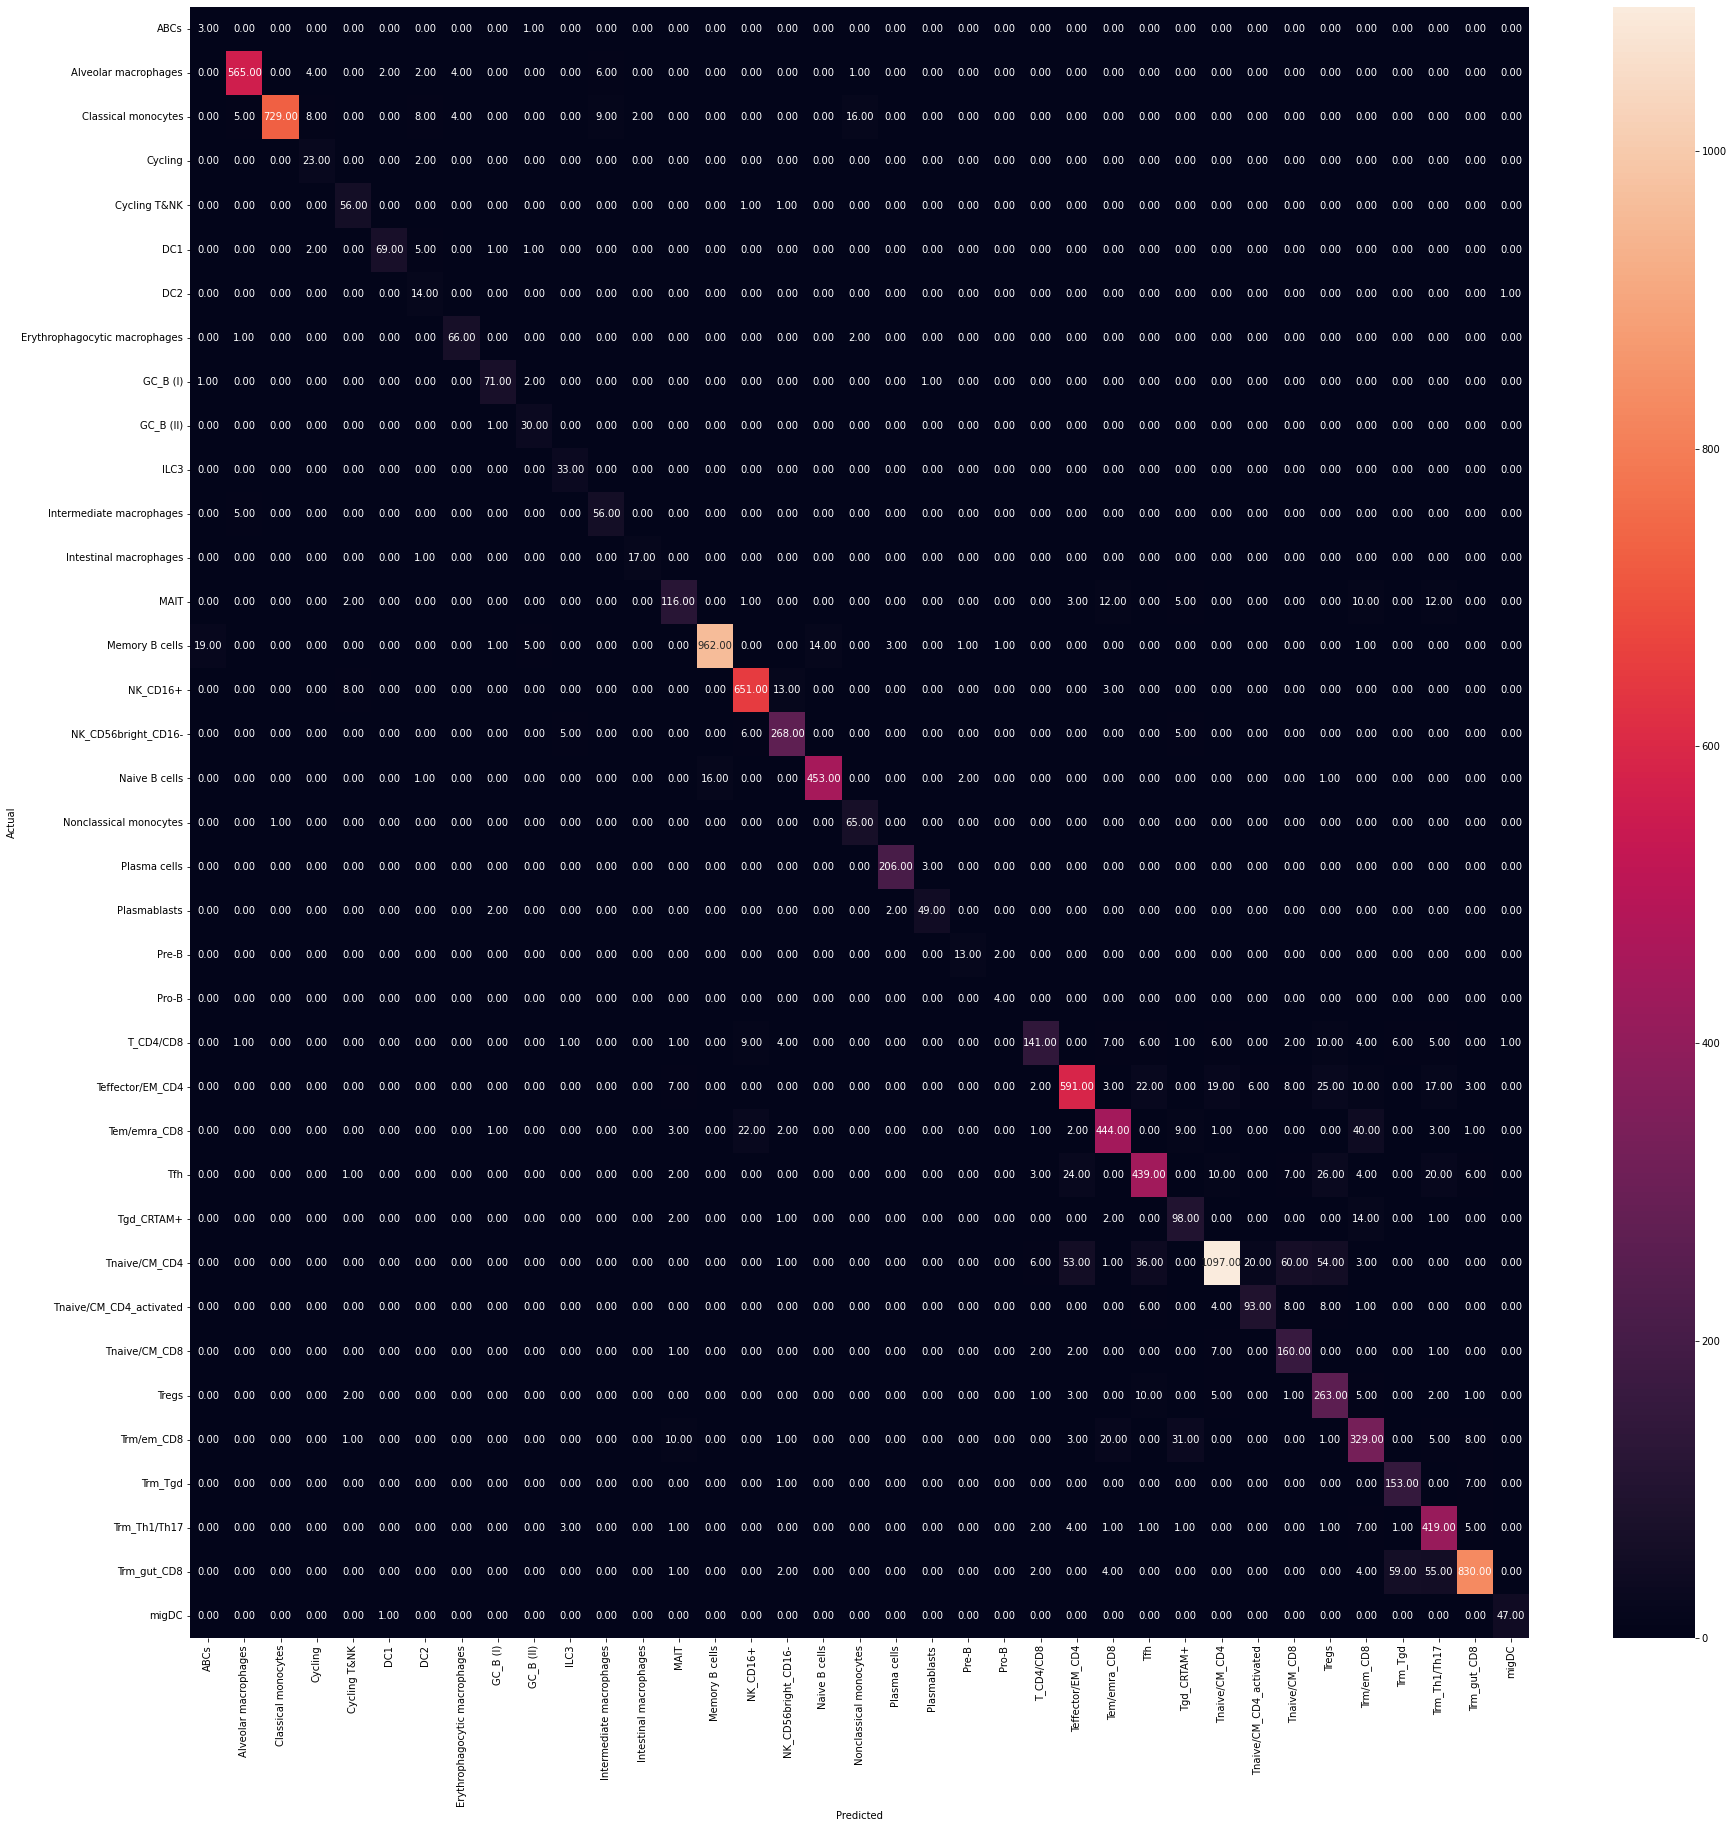

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test, pred)
# Normalise
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                    yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show(block=False)

In [11]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(128, 32), random_state=1)

clf.fit(X_train, y_train)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(128, 32), random_state=1,
              solver='lbfgs')

In [12]:
clf.score(X_test, y_test)

0.8890428677014043

In [13]:
y_test = clf.predict(X_test)

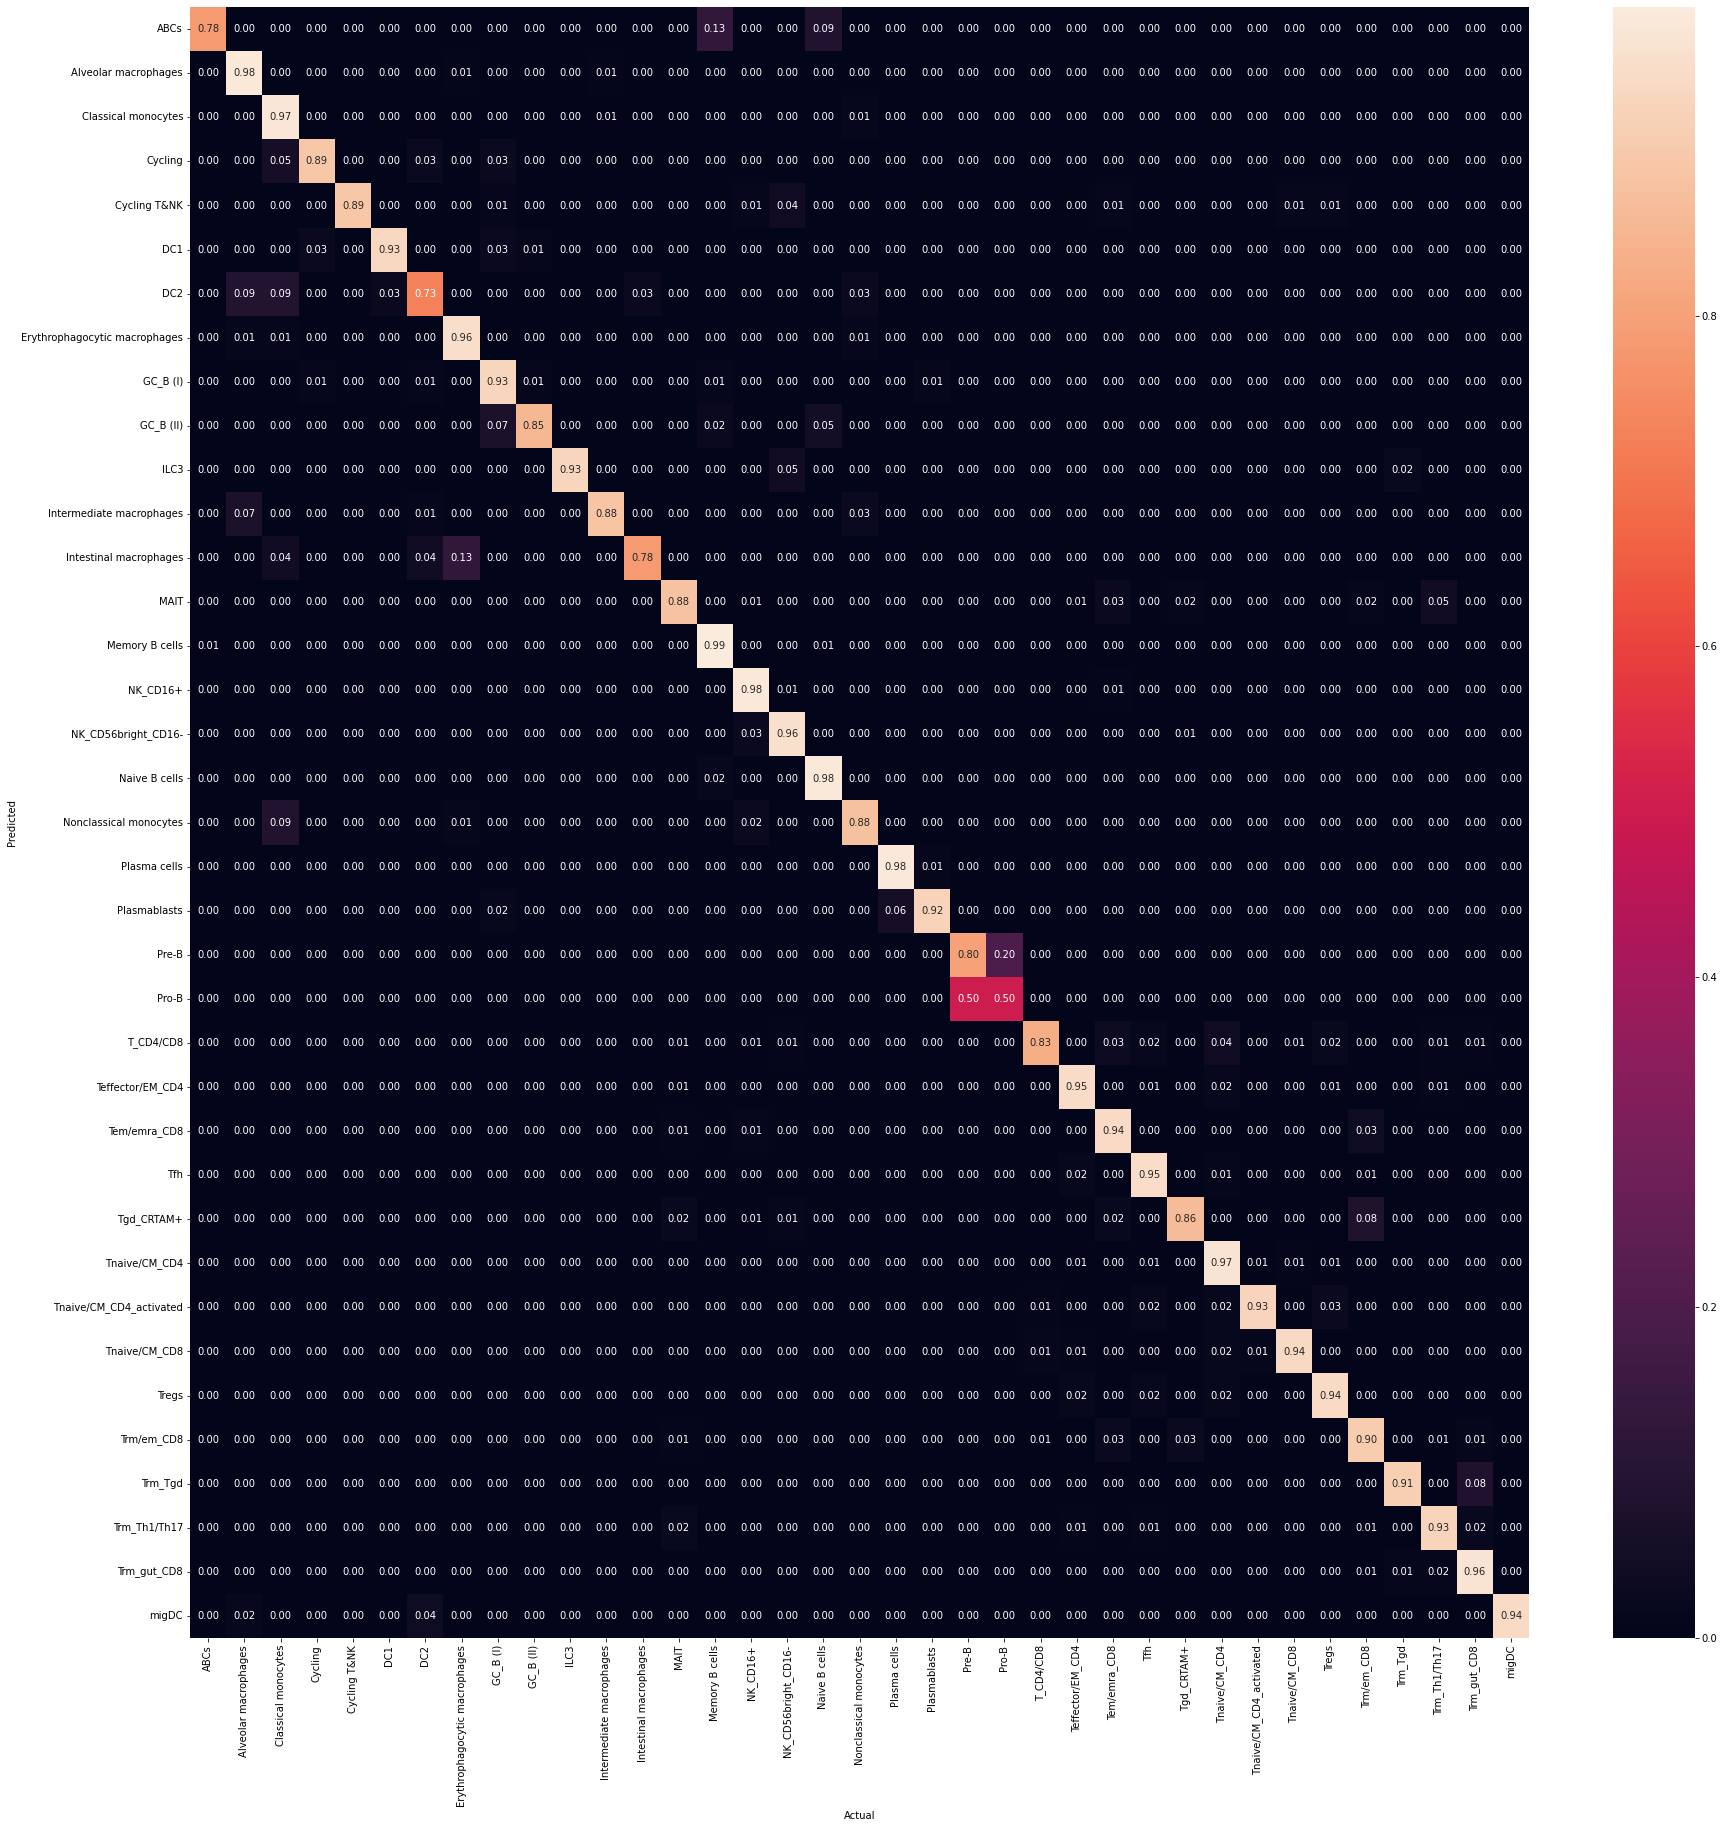

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test, pred)
# Normalise
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                    yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show(block=False)